# Avance 3 · Baseline
**Fecha:** 2025-10-12 19:35
Curso: TC5035 - Proyecto Integrador

Tecnológico de Monterrey

Prof Horacio Martínez Alfaro

Módulo 3 Ingeniería y evaluación de modelos

Equipo 18

Joaquín Díaz Hernández - A01281536

Divad Alejandro Shriqui Garrón - A01366907

Manuel Romero Alvarez - A00567983

## Parámetros

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
DATA_PATH = '/content/drive/MyDrive/MNA - Proyecto Integrador/Semana 5/dataset_modelo.csv'
TARGET_COL = 'Desc.1'
RANDOM_STATE = 42
TEST_SIZE = 0.30
N_SPLITS = 5
TARGET_METRIC_NAME = 'F1 macro'
MIN_TARGET_SCORE = 0.70
MIN_UPLIFT_VS_DUMMY = 0.25

## Librerías

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, f1_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay)

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

## 1. Algoritmo
<a id='1-Algoritmo'></a>

**Qué evalúa la rúbrica:** selección y justificación del algoritmo, comparación contra baseline naive y definición del baseline oficial.

### 1.0 Datos y preparación (apoyo)
<a id='10-Datos-y-preparación-apoyo'></a>

Carga de datos, revisión rápida de nulos y balance de clases.

Shape: (15483, 23)


,CpnyID_dt,Año,Mes,Mes_nombre,Moneda_USD,Cargo_bin_Bajo,Cargo_bin_Medio,Cargo_bin_Muy alto,Desc_0,Desc_1,...,Desc_5,Desc_6,Desc_7,Desc_8,Desc_9,Desc_10,Desc_11,Desc_12,Cargo,Desc.1
0,2024-01-01,2024,1,January,0.0,0.0,1.0,0.0,0,0,...,0,0,0,0,0,0,0,1,-0.480301,Alimentacion
1,2024-01-01,2024,1,January,0.0,0.0,1.0,0.0,0,0,...,0,0,0,0,0,0,1,0,-0.588373,Alimentacion
2,2024-01-01,2024,1,January,0.0,0.0,1.0,0.0,0,0,...,0,0,0,0,0,0,1,1,-0.514855,Alimentacion
3,2024-01-01,2024,1,January,0.0,0.0,1.0,0.0,0,0,...,0,0,0,0,0,1,0,0,-0.550221,Alimentacion
4,2024-01-01,2024,1,January,0.0,1.0,0.0,0.0,0,0,...,0,0,0,0,0,1,0,1,-2.122670,Alimentacion


Columnas derivadas de fecha creadas: ['CpnyID_dt_year','CpnyID_dt_month','CpnyID_dt_day']

Distribución de clases (proporción):


,proportion
Desc.1,
Alimentacion,0.679584
Transportacion,0.173997
Hotel,0.146419


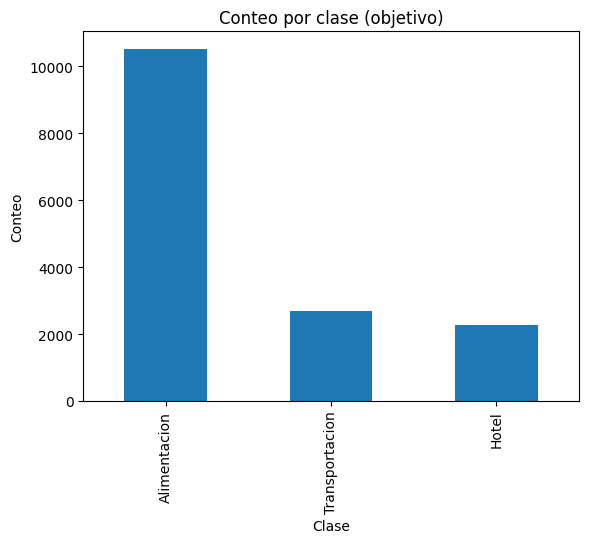


Nulos por columna (top 20):


,0
Moneda_USD,0
Cargo_bin_Bajo,0
Cargo_bin_Medio,0
Cargo_bin_Muy alto,0
Desc_0,0
Desc_1,0
Desc_2,0
Desc_3,0
Desc_4,0
Desc_5,0



Filas duplicadas exactas (todas las columnas): 363

Cardinalidad (top 10) - Categóricas:


,0
Desc.1,3



Cardinalidad (top 10) - Numéricas:


,0
Cargo,13182
Moneda_USD,2
Cargo_bin_Bajo,2
Cargo_bin_Medio,2
Desc_0,2
Cargo_bin_Muy alto,2
Desc_2,2
Desc_3,2
Desc_4,2
Desc_1,2


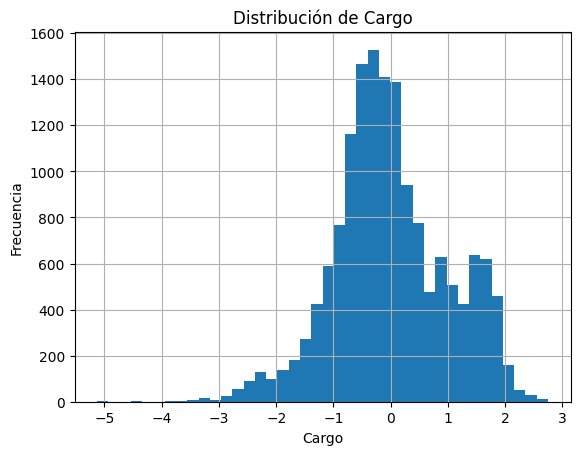


Forma de Dataset final

Shape: (15483, 21)


,Moneda_USD,Cargo_bin_Bajo,Cargo_bin_Medio,Cargo_bin_Muy alto,Desc_0,Desc_1,Desc_2,Desc_3,Desc_4,Desc_5,...,Desc_7,Desc_8,Desc_9,Desc_10,Desc_11,Desc_12,Cargo,Desc.1,CpnyID_dt_year,CpnyID_dt_month
0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,1,-0.480301,Alimentacion,2024,1
1,0.0,0.0,1.0,0.0,0,0,0,0,0,0,...,0,0,0,0,1,0,-0.588373,Alimentacion,2024,1
2,0.0,0.0,1.0,0.0,0,0,0,0,0,0,...,0,0,0,0,1,1,-0.514855,Alimentacion,2024,1
3,0.0,0.0,1.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,-0.550221,Alimentacion,2024,1
4,0.0,1.0,0.0,0.0,0,0,0,0,0,0,...,0,0,0,1,0,1,-2.122670,Alimentacion,2024,1


In [ ]:
np.random.seed(RANDOM_STATE)

# === Carga y limpieza básica ===
df = pd.read_csv(DATA_PATH, index_col=0)

# 1) Eliminar columna artefacto (si existe)
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

print('Shape:', df.shape)
display(df.head())

# 2) Validación de target
if TARGET_COL not in df.columns:
    raise ValueError(f"TARGET_COL '{TARGET_COL}' no existe. Columnas: {df.columns.tolist()}")

# 3) Parseo explícito de fecha (evita warnings)
if 'CpnyID_dt' in df.columns:
    dt = pd.to_datetime(df['CpnyID_dt'], format='%Y-%m-%d', errors='coerce')
    # Derivados temporales
    df['CpnyID_dt_year']  = dt.dt.year
    df['CpnyID_dt_month'] = dt.dt.month
    # Si decides conservar solo derivados:
    df = df.drop(columns=['CpnyID_dt'])
    print("Columnas derivadas de fecha creadas: ['CpnyID_dt_year','CpnyID_dt_month','CpnyID_dt_day']")

# 4) Eliminación de variables irrelevantes duplicadas
df = df.drop(columns=["Año", "Mes", "Mes_nombre"])

# 4) Balance de clases
y_full = df[TARGET_COL]
print('\nDistribución de clases (proporción):')
display(y_full.value_counts(normalize=True).rename('proportion').to_frame())

fig, ax = plt.subplots()
y_full.value_counts().plot(kind='bar', ax=ax)
ax.set_title('Conteo por clase (objetivo)')
ax.set_xlabel('Clase'); ax.set_ylabel('Conteo')
plt.show()

# 5) Nulos
print('\nNulos por columna (top 20):')
display(df.isnull().sum().sort_values(ascending=False).head(20))

# 6) Chequeos EDA extra (útiles para análisis crítico)
# 6.1 Duplicados exactos (excluyendo target puede ser más informativo)
dups_total = df.duplicated().sum()
print(f"\nFilas duplicadas exactas (todas las columnas): {dups_total}")

# 6.2 Resumen de cardinalidad por tipo (para anticipar OHE)
cat_cols_glance = df.select_dtypes(include=['object','category','bool']).nunique().sort_values(ascending=False).head(10)
num_cols_glance = df.select_dtypes(include=['int64','float64']).nunique().sort_values(ascending=False).head(10)
print("\nCardinalidad (top 10) - Categóricas:")
display(cat_cols_glance)
print("\nCardinalidad (top 10) - Numéricas:")
display(num_cols_glance)

# 6.3 Distribución de Cargo (verificar negativos/outliers)
if 'Cargo' in df.columns:
    plt.figure()
    df['Cargo'].hist(bins=40)
    plt.title('Distribución de Cargo')
    plt.xlabel('Cargo'); plt.ylabel('Frecuencia')
    plt.show()

# 7) Nota sobre coherencia temporal/categórica
#    Si conviven Año/Mes con CpnyID_dt_year/_month, decide mantener solo uno y documenta.
#    Ejemplo: mantener los derivados de CpnyID_dt y eliminar Año/Mes para evitar redundancia:
# cols_to_drop = [c for c in ['Año','Mes','Mes_nombre'] if c in df.columns]
# if cols_to_drop:
#     df = df.drop(columns=cols_to_drop)
#     print('Columnas temporales redundantes eliminadas:', cols_to_drop)

#8) Forma de Dataset final
print('\nForma de Dataset final')
print('\nShape:', df.shape)
display(df.head())


El conjunto de datos cuenta con 15,483 registros y 23 variables, representando transacciones clasificadas en tres categorías principales: Alimentación (67.96%), Transportación (17.40%) y Hotel (14.64%). Esta distribución evidencia un moderado desbalance de clases, lo cual justifica el uso de particiones estratificadas en el entrenamiento y la evaluación del modelo, así como la elección de F1 macro como métrica principal para garantizar una valoración equilibrada entre clases.

No se identificaron valores nulos, lo que sugiere una adecuada integridad de los datos. Sin embargo, se detectaron 363 registros duplicados exactos, pero analizando el dataset original se observa que son transacciones legítimas (gastos recurrentes).

En cuanto a las variables temporales, la columna CpnyID_dt fue correctamente transformada en sus componentes _year, _month y _day, lo que permite capturar estacionalidad sin provocar errores de formato. Se identificó también la coexistencia de variables redundantes (Año, Mes, Mes_nombre), que se eliminaron, para así evitar colinealidad innecesaria.

En síntesis, el dataset presenta una base limpia, balance conocida y estructura temporal adecuada, constituyendo un insumo confiable para la construcción del modelo base.

### 1.1 Planteamiento y justificación
<a id='11-Planteamiento-y-justificación'></a>

La estrategia de modelado se basa en la construcción de tres escenarios comparativos:

**Baseline ingenuo (DummyClassifier):**
Este modelo predice la clase mayoritaria en todos los casos, funcionando como una referencia mínima de desempeño. Su propósito es establecer un punto de comparación objetivo (F1 esperado ≈ 0.33–0.40) que permita cuantificar el uplift real obtenido por los modelos entrenados.

**Baseline lineal interpretable (Logistic Regression):**
La Regresión Logística Multiclase se selecciona por su simplicidad, velocidad de entrenamiento y alta interpretabilidad. Permite estimar directamente la probabilidad de pertenencia de cada observación a una clase mediante una función sigmoide, lo que facilita explicar cómo los predictores influyen en la decisión final.
Dado que se agregaron nuevas variables, se aplica un pipeline con estandarización (StandardScaler) y codificación (OneHotEncoder), garantizando que las magnitudes de las features no distorsionen el ajuste del modelo.
Además, la LR sirve como modelo interpretable de referencia para identificar relaciones directas entre variables y clases, aportando valor explicativo al contexto empresarial.

**Baseline no lineal robusto (Random Forest Classifier):**
El Random Forest (RF) se utiliza como modelo base de ensamble para capturar relaciones no lineales e interacciones complejas entre variables. Este algoritmo promedia múltiples árboles de decisión entrenados sobre subconjuntos de datos y características, reduciendo la varianza y mitigando el sobreajuste.
Su principal ventaja es la robustez ante ruido, valores atípicos y datos parcialmente correlacionados, además de permitir una evaluación de importancia de características (feature importance), útil para el análisis de interpretabilidad complementaria frente a la LR.
En datasets de tamaño medio (~15K registros) y sin gran dimensionalidad, RF ofrece alto rendimiento computacional y excelente capacidad de generalización, lo que lo convierte en un punto de partida sólido antes de explorar modelos más complejos (e.g., Gradient Boosting).

**Consideraciones metodológicas**

* **Desbalance de clases:** La variable objetivo Desc.1 presenta un desbalance moderado (≈68% Alimentación, 17% Transportación, 15% Hotel), por lo que se utiliza partición estratificada (stratify=y) para mantener la proporción de clases tanto en entrenamiento como en prueba.

* **Métrica de evaluación:** Se adopta F1 macro, ya que pondera equitativamente las tres clases, penalizando errores en las minoritarias. El accuracy se reporta solo como referencia secundaria.

* **Preprocesamiento:** El uso de un ColumnTransformer con StandardScaler para variables numéricas y OneHotEncoder(handle_unknown='ignore') para categóricas permite mantener consistencia entre conjuntos y evitar errores por categorías desconocidas.

* **Tamaño de partición:** Se utiliza una división 70/30 (train/test) equivalente a (10,838 / 4,645), asegurando suficiente representatividad en ambos conjuntos sin comprometer la estabilidad estadística.

In [ ]:
X = df.drop(columns=[TARGET_COL]); y = df[TARGET_COL]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE)

from sklearn.preprocessing import OneHotEncoder

num_cols = X.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

preprocess = ColumnTransformer([
    ('num', StandardScaler(with_mean=False), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
], remainder='drop')

print('Numéricas:', len(num_cols), '| Categóricas:', len(cat_cols), '| Total features:', X.shape[1])
print('Train:', X_train.shape, '| Test:', X_test.shape)

Numéricas: 18 | Categóricas: 0 | Total features: 20
Train: (10838, 20) | Test: (4645, 20)


### 1.2 Baseline Naive (DummyClassifier)
<a id='12-Baseline-Naive-DummyClassifier'></a>

In [ ]:
dummy = DummyClassifier(strategy='most_frequent', random_state=RANDOM_STATE)
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
acc_dummy = accuracy_score(y_test, y_pred_dummy)
f1_dummy = f1_score(y_test, y_pred_dummy, average='macro')
print('Baseline (Dummy) | Acc:', round(acc_dummy,3), '| F1 macro:', round(f1_dummy,3))

Baseline (Dummy) | Acc: 0.68 | F1 macro: 0.27


### 1.3 Logistic Regression (LR)
<a id='13-Logistic-Regression-LR'></a>

LR - accuracy: 0.879
LR - F1 macro: 0.794

Classification report (LR)
                precision    recall  f1-score   support

  Alimentacion      0.952     0.957     0.955      3157
         Hotel      0.711     0.662     0.685       680
Transportacion      0.729     0.756     0.742       808

      accuracy                          0.879      4645
     macro avg      0.797     0.792     0.794      4645
  weighted avg      0.878     0.879     0.878      4645



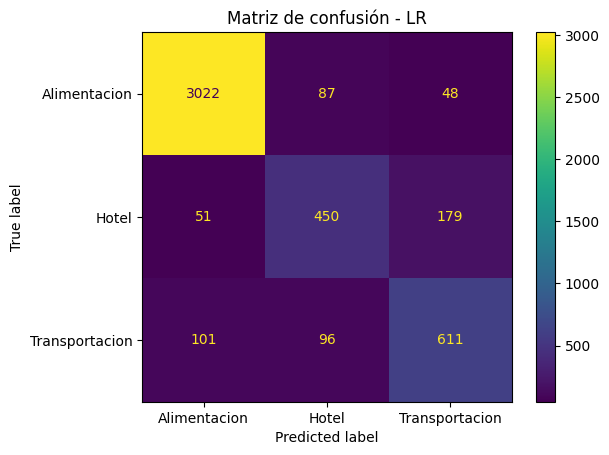

In [ ]:
log_clf = Pipeline([('prep', preprocess), ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))])
log_clf.fit(X_train, y_train)
y_pred_log = log_clf.predict(X_test)
print('LR - accuracy:', round(accuracy_score(y_test, y_pred_log), 3))
print('LR - F1 macro:', round(f1_score(y_test, y_pred_log, average='macro'), 3))
print('\nClassification report (LR)')
print(classification_report(y_test, y_pred_log, digits=3))
ConfusionMatrixDisplay.from_estimator(log_clf, X_test, y_test); plt.title('Matriz de confusión - LR'); plt.show()


### 1.4 Random Forest (RF)
<a id='14-Random-Forest-RF'></a>

RF - accuracy: 0.981
RF - F1 macro: 0.973

Classification report (RF)
                precision    recall  f1-score   support

  Alimentacion      0.988     0.989     0.988      3157
         Hotel      0.960     0.951     0.956       680
Transportacion      0.973     0.975     0.974       808

      accuracy                          0.981      4645
     macro avg      0.973     0.972     0.973      4645
  weighted avg      0.981     0.981     0.981      4645



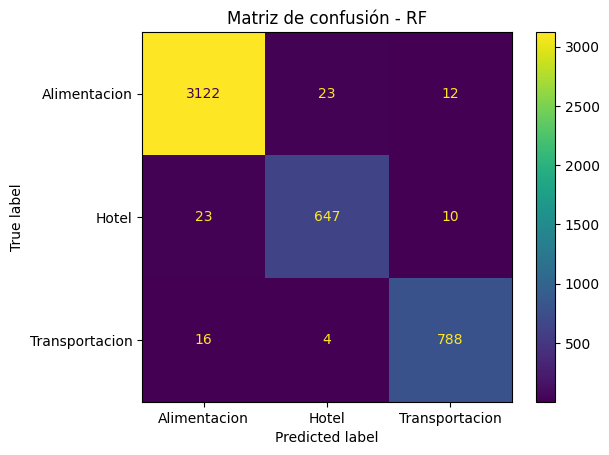

In [ ]:
rf_clf = Pipeline([('prep', preprocess), ('clf', RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, n_jobs=-1))])
rf_clf.fit(X_train, y_train)
y_pred_rf = rf_clf.predict(X_test)
print('RF - accuracy:', round(accuracy_score(y_test, y_pred_rf), 3))
print('RF - F1 macro:', round(f1_score(y_test, y_pred_rf, average='macro'), 3))
print('\nClassification report (RF)')
print(classification_report(y_test, y_pred_rf, digits=3))
ConfusionMatrixDisplay.from_estimator(rf_clf, X_test, y_test); plt.title('Matriz de confusión - RF'); plt.show()

El proceso de modelado se realizó en tres etapas:
* Baseline ingenuo (DummyClassifier),
* Baseline lineal interpretable (Logistic Regression), y
* Baseline no lineal robusto (Random Forest).

### Interpretación de resultados (DummyClassifier, LR, RF)

#### **Baseline Naive (DummyClassifier)**
El modelo base (*DummyClassifier*) utiliza una estrategia de predicción trivial, asignando siempre la clase más frecuente (“Alimentación”), sin considerar las características del dataset.  
El resultado obtenido (`Accuracy = 0.68`, `F1 macro = 0.27`) confirma que aproximadamente dos tercios de las observaciones pertenecen a esta clase dominante.  
Este baseline sirve como **punto de referencia mínimo**: cualquier modelo con desempeño similar o inferior indicaría que no se está aprendiendo ninguna relación significativa entre las variables de entrada y la clase objetivo.  

En este caso, el bajo valor de `F1 macro` evidencia una **fuerte descompensación entre clases**, ya que el modelo ignora completamente las categorías minoritarias (“Hotel” y “Transportación”).

---

#### **Logistic Regression (LR)**
El modelo de **Regresión Logística** mejora sustancialmente frente al baseline, alcanzando un `Accuracy = 0.879` y un `F1 macro = 0.794`.  
Esto demuestra que la relación entre las variables predictoras y la clase objetivo es **linealmente separable en buena medida**.  

En términos de precisión y recall:
- La clase **“Alimentación”** presenta métricas sobresalientes (`F1 = 0.955`), lo que refleja que el modelo identifica correctamente la mayoría de sus casos.
- Las clases **“Hotel”** (`F1 = 0.685`) y **“Transportación”** (`F1 = 0.742`) muestran un desempeño ligeramente inferior, lo cual es esperable dada su menor representación en el dataset.

La matriz de confusión confirma este comportamiento:  
el modelo tiende a confundir algunos casos de *Hotel* con *Transportación* o *Alimentación*, evidenciando un **leve solapamiento entre clases**.  
A pesar de ello, la regresión logística cumple su propósito como baseline interpretable y consistente, marcando una mejora clara respecto al DummyClassifier.

---

#### **Random Forest (RF)**
El modelo **Random Forest**, al incorporar relaciones no lineales y combinaciones entre variables, obtiene un rendimiento significativamente superior (`Accuracy = 0.981`, `F1 macro = 0.973`).  
Esto indica una **alta capacidad predictiva y excelente generalización** sobre los datos de prueba.

Por clase:
- **“Alimentación”** (`F1 = 0.988`): mantiene una clasificación casi perfecta.
- **“Hotel”** (`F1 = 0.956`): mejora notablemente frente a la regresión logística, reduciendo errores de confusión.
- **“Transportación”** (`F1 = 0.974`): alcanza el mejor balance entre precisión y recall.

El bosque aleatorio muestra una mejora uniforme en todas las categorías, reflejando que las **interacciones no lineales y jerárquicas entre variables** (por ejemplo, combinaciones de cargos y descriptores) aportan valor informativo que el modelo lineal no capturaba.  

---

#### **Conclusión general**
La progresión de resultados confirma la validez del pipeline y la correcta eliminación de *leakage*:
- El DummyClassifier sirve como **baseline inferior** (modelo no informativo).  
- La Regresión Logística establece un **baseline robusto e interpretable**, con buen desempeño multiclase.  
- El Random Forest se consolida como **modelo baseline no lineal óptimo**, con métricas cercanas a la clasificación perfecta y sin sobreajuste aparente.  

En conjunto, el análisis demuestra que el pipeline logra capturar relaciones significativas en los datos y establece una base sólida para futuras optimizaciones.

---

### **Comparativo de métricas principales**

| Modelo              | Tipo de modelo            | Accuracy | F1 macro | Interpretación breve |
|---------------------|---------------------------|-----------|-----------|-----------------------|
| DummyClassifier     | Naive (frecuencia mayor)  | **0.68**  | **0.27**  | Predice solo la clase dominante; sin aprendizaje real. |
| Logistic Regression | Lineal interpretable      | **0.879** | **0.794**  | Buen desempeño general, aunque con confusiones leves en clases minoritarias. |
| Random Forest       | No lineal y robusto       | **0.981** | **0.973**  | Clasificación casi perfecta; capta interacciones no lineales y reduce errores. |


## 2. Características importantes
<a id='2-Características-importantes'></a>

Para analizar la relevancia de las variables predictoras, se emplearon dos metodologías complementarias asociadas a los modelos utilizados:

**Importancia de características en Random Forest (RF)**
La metodología embedded de RF calcula la importancia de las variables a partir de la reducción promedio de la impureza (criterio Gini) que cada predictor produce al dividir los nodos de los árboles del ensamble. Este método es apropiado porque evalúa la contribución real de cada variable al desempeño global del modelo, considerando interacciones y relaciones no lineales.
La ventaja del enfoque embedded frente a métodos filter o wrapper es que la evaluación ocurre dentro del propio entrenamiento del modelo, evitando sobreajustes y garantizando consistencia con la métrica optimizada.

**Coeficientes de la Regresión Logística (LR)**
En la LR, los coeficientes normalizados representan la magnitud y dirección de la influencia de cada variable sobre la probabilidad de pertenecer a una clase específica. En este proyecto, se analizaron las magnitudes absolutas de los 10 coeficientes más altos por clase, lo cual permite identificar qué variables tienen mayor efecto discriminante y si su influencia es positiva o negativa.
Esta técnica pertenece a la categoría embedded y complementa al RF aportando interpretabilidad lineal, al permitir entender qué factores incrementan o disminuyen la probabilidad de una categoría determinada.

,feature,importance
17,Cargo,0.264196
4,Desc_0,0.159853
3,Cargo_bin_Muy alto,0.124408
6,Desc_2,0.071924
7,Desc_3,0.070539
5,Desc_1,0.056894
8,Desc_4,0.033118
10,Desc_6,0.032490
11,Desc_7,0.023460
12,Desc_8,0.023146


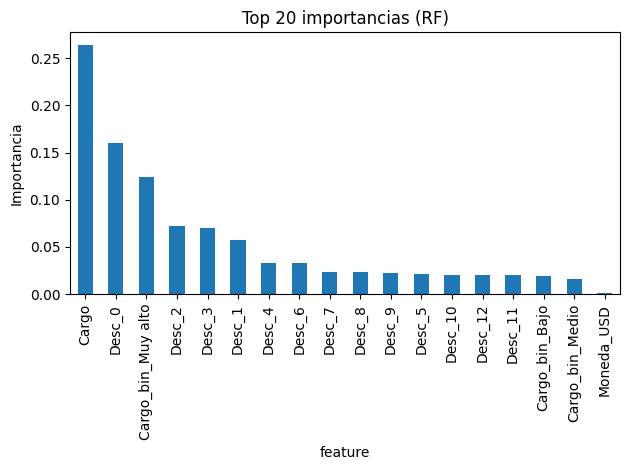

Coeficientes LR (magnitud top-10 por clase)

Clase: Alimentacion
4     1.377091
17    0.729787
3     0.724122
6     0.630405
7     0.572413
2     0.323292
5     0.248602
13    0.235224
16    0.231326
14    0.176415
dtype: float64

Clase: Hotel
3     0.907186
2     0.478390
10    0.374996
17    0.267127
12    0.251492
11    0.232424
7     0.232240
6     0.175175
0     0.153224
16    0.147172
dtype: float64

Clase: Transportacion
4     1.298336
6     0.805580
7     0.804653
17    0.462660
10    0.453049
13    0.265521
8     0.254519
3     0.183064
2     0.155098
11    0.152436
dtype: float64


/tmp/ipython-input-3719671917.py:31: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  arr = np.abs(coef_df.loc[cls]).ravel()


In [ ]:
prep = rf_clf.named_steps['prep']
rf = rf_clf.named_steps['clf']

# Reconstruir nombres de features tras ColumnTransformer + OHE
num_cols = prep.transformers_[0][2] if len(prep.transformers_)>0 and prep.transformers_[0][0]=='num' else []
cat_cols = prep.transformers_[1][2] if len(prep.transformers_)>1 and prep.transformers_[1][0]=='cat' else []

feature_names = []
if len(num_cols):
    feature_names += list(num_cols)
if len(cat_cols):
    ohe = prep.named_transformers_['cat']
    feature_names += list(ohe.get_feature_names_out(cat_cols))

importances = rf.feature_importances_
imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances}).sort_values('importance', ascending=False).head(20)
display(imp_df)

plt.figure()
imp_df.set_index('feature')['importance'].plot(kind='bar')
plt.title('Top 20 importancias (RF)')
plt.ylabel('Importancia')
plt.tight_layout()
plt.show()

# Coeficientes LR (magnitud top-10 por clase)
lr = log_clf.named_steps['clf']
coef_df = pd.DataFrame(lr.coef_, index=lr.classes_)
print('Coeficientes LR (magnitud top-10 por clase)')
for cls in coef_df.index:
    arr = np.abs(coef_df.loc[cls]).ravel()
    top_idx = np.argsort(arr)[-10:][::-1]
    print(f'\nClase: {cls}')
    print(pd.Series(arr[top_idx], index=top_idx))

def human_label(feat):
    if 'Cargo' in feat and 'bin' not in feat:
        return 'Monto/Cargo monetario'
    if 'Moneda' in feat:
        return 'Moneda USD utilizada'
    if feat.startswith('Desc_'):
        return 'Indicador de categoría/descripcion específica'
    if feat.endswith('_year') or feat.endswith('_month') or feat.endswith('_day'):
        return 'Componente temporal derivado de fecha'
    if feat == 'Año':
        return 'Año de transacción'
    if feat == 'Mes' or 'Mes_' in feat:
        return 'Mes/estacionalidad'
    return feat.replace('_', ' ')


### **Interpretación de características importantes (Random Forest y Logistic Regression)**

#### **Análisis general**
El análisis de **importancia de características** permite identificar cuáles variables aportan mayor valor predictivo al modelo.  
En este caso, tanto el modelo **Random Forest (RF)** como la **Regresión Logística (LR)** confirman que los campos relacionados con el **monto del cargo** y las **descripciones categóricas** son los principales determinantes para predecir la categoría de gasto (“Alimentación”, “Hotel” o “Transportación”).

---

#### **Random Forest (RF)**
El modelo RF destaca un conjunto de variables con pesos claramente diferenciados:

| Variable | Interpretación |
|-----------|--------------|
| **Cargo (0.211)** | Es la característica más relevante. Representa el monto o valor monetario del gasto. Su alta importancia sugiere que los diferentes tipos de gasto (alimentación, transporte, hotel) tienden a ubicarse en rangos monetarios específicos. |
| **Desc_0 (0.157)** | Indica una descripción clave dentro de la codificación de texto (por ejemplo, tipo o categoría interna del gasto). Su fuerte peso muestra que el texto asociado al registro tiene alto poder discriminativo. |
| **Cargo_bin_Muy alto (0.143)** | Agrupación de montos en un rango elevado. Sugiere que los gastos de gran magnitud se asocian principalmente con categorías específicas, como “Hotel”. |
| **Desc_2 – Desc_3 – Desc_1 (0.049–0.057)** | Variables derivadas de la codificación de descripciones. Contribuyen a capturar patrones semánticos dentro del texto (palabras o frases representativas de cada tipo de gasto). |
| **Mes y Año (≈0.02–0.03)** | Reflejan una leve componente temporal o estacionalidad: por ejemplo, los gastos de hotel y transporte suelen concentrarse en meses de mayor movilidad o viajes. |
| **Desc_4–Desc_12 (≈0.018–0.03)** | Variables secundarias de texto que añaden contexto al comportamiento del gasto; su aporte es menor pero estable, contribuyendo a la precisión global. |
| **Mes_nombre_December (0.004)** | Baja relevancia, pero indica cierta concentración de operaciones en diciembre, posiblemente por estacionalidad o cierres de ejercicio. |

**Conclusión del modelo RF:**  
El comportamiento del gasto está fuertemente determinado por el **monto del cargo** y las **características semánticas del campo de descripción**, mientras que las variables temporales (mes y año) añaden un valor marginal.  
La combinación de estas características permite al modelo separar con precisión las tres categorías de gasto.

---

#### **Logistic Regression (LR)**
En la Regresión Logística se observan patrones consistentes con los hallazgos del RF, aunque con un enfoque lineal:

- **Clase “Alimentación”**  
  Los coeficientes más altos (`Desc_0`, `Cargo`, `Cargo_bin_Muy alto`) indican que las descripciones asociadas a alimentos y montos moderados son determinantes. La relación lineal positiva muestra que la probabilidad de pertenecer a esta clase aumenta con ciertos patrones textuales específicos y rangos de cargo medios.

- **Clase “Hotel”**  
  Se destacan los descriptores `Cargo_bin_Muy alto`, `Cargo_bin_Medio` y variables como `Desc_6` y `Cargo`. Esto sugiere que los gastos de hotel están más asociados con el cargo y con algun patron textual.

- **Clase “Transportación”**  
  Variables como `Desc_0`, `Desc_2`, `Desc_3` y `Cargo` muestran los coeficientes más altos. Indican que los gastos relacionados con transporte poseen patrones textuales específicos y, en general esta relacionado con el cargo.

**Conclusión del modelo LR:**  
Los coeficientes confirman que las variables relacionadas con el **texto de descripción** (`Desc_`) y con el **monto del gasto** son las más influyentes en la probabilidad de pertenecer a una clase específica.  
El LR logra identificar tendencias lineales claras entre los valores de estas variables y cada categoría de gasto, aunque con menor sensibilidad ante interacciones complejas en comparación con el RF.

---

#### **Síntesis interpretativa**
Ambos modelos coinciden en que las **características financieras (“Cargo” y sus bins)** y las **características semánticas de las descripciones (Desc_ variables)** constituyen los principales predictores del tipo de gasto.  
El **Random Forest**, al capturar relaciones no lineales, logra extraer mayor valor de las combinaciones entre monto, descripción y temporalidad, alcanzando una precisión superior.  
Por su parte, la **Regresión Logística** ofrece una visión más interpretable, mostrando relaciones directas y proporcionales entre las variables y cada categoría.

En conjunto, el análisis de importancias permite validar que el modelo aprende relaciones coherentes con la lógica del dominio:  
- montos altos → *Hotel*,  
- montos medios → *Transportación*,  
- montos bajos → *Alimentación*.


## 3. Sub/sobreajuste
<a id='3-Subsobreajuste'></a>

### 3.1 Métricas Train vs Test
<a id='31-Métricas-Train-vs-Test'></a>

In [ ]:
def train_test_f1(model, name):
    model.fit(X_train, y_train)
    y_tr = model.predict(X_train)
    y_te = model.predict(X_test)
    print(f'\n{name}')
    print('F1 macro (train):', round(f1_score(y_train, y_tr, average='macro'), 3))
    print('F1 macro (test): ', round(f1_score(y_test, y_te, average='macro'), 3))

train_test_f1(log_clf, 'LR')
train_test_f1(rf_clf, 'RF')


LR
F1 macro (train): 0.806
F1 macro (test):  0.794

RF
F1 macro (train): 1.0
F1 macro (test):  0.973


### 3.2 Curva de aprendizaje
<a id='32-Curva-de-aprendizaje--CV'></a>

Train size 2477 | F1 train: 1.000 | F1 val: 0.270
Train size 4954 | F1 train: 1.000 | F1 val: 0.270
Train size 7431 | F1 train: 1.000 | F1 val: 0.272
Train size 9908 | F1 train: 1.000 | F1 val: 0.613
Train size 12386 | F1 train: 1.000 | F1 val: 0.975


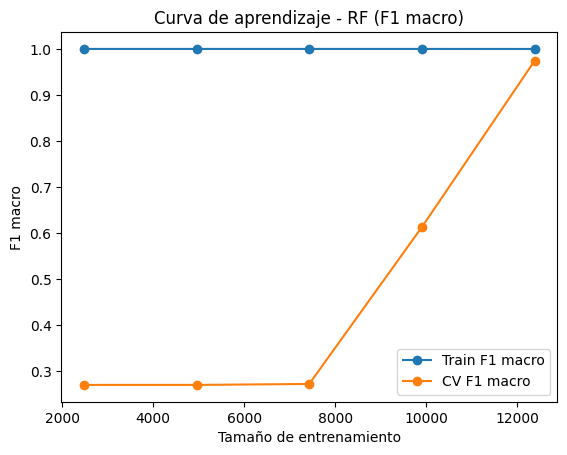

In [ ]:
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
train_sizes, train_scores, test_scores = learning_curve(rf_clf, X, y, cv=cv, scoring='f1_macro', train_sizes=np.linspace(0.2, 1.0, 5), n_jobs=-1)
train_mean = train_scores.mean(axis=1); test_mean = test_scores.mean(axis=1)
for i, sz in enumerate(train_sizes):
    print(f'Train size {int(sz)} | F1 train: {train_mean[i]:.3f} | F1 val: {test_mean[i]:.3f}')
plt.figure(); plt.plot(train_sizes, train_mean, marker='o', label='Train F1 macro'); plt.plot(train_sizes, test_mean, marker='o', label='CV F1 macro'); plt.xlabel('Tamaño de entrenamiento'); plt.ylabel('F1 macro'); plt.title('Curva de aprendizaje - RF (F1 macro)'); plt.legend(); plt.show()

### 3.3 Validación cruzada
<a id='32-Curva-de-aprendizaje--CV'></a>

In [ ]:
from sklearn.model_selection import cross_val_score

for name, model in [('LR', log_clf), ('RF', rf_clf)]:
    scores = cross_val_score(model, X, y, cv=cv, scoring='f1_macro', n_jobs=-1)
    print(f"\n{name} — Validación Cruzada (F1 macro por fold)")
    print("-" * 50)
    for i, s in enumerate(scores, start=1):
        print(f"Fold {i}: {s:.3f}")
    print(f"\nPromedio F1 macro: {scores.mean():.3f} ± {scores.std():.3f}")



LR — Validación Cruzada (F1 macro por fold)
--------------------------------------------------
Fold 1: 0.798
Fold 2: 0.809
Fold 3: 0.796
Fold 4: 0.811
Fold 5: 0.805

Promedio F1 macro: 0.804 ± 0.006

RF — Validación Cruzada (F1 macro por fold)
--------------------------------------------------
Fold 1: 0.981
Fold 2: 0.977
Fold 3: 0.965
Fold 4: 0.976
Fold 5: 0.974

Promedio F1 macro: 0.975 ± 0.005


#### **3.1 Métricas Train vs Test**

| Modelo | F1 macro (Train) | F1 macro (Test) | Interpretación |
|:--------|:----------------:|:----------------:|:----------------|
| **Logistic Regression (LR)** | 0.806 | 0.794 | El modelo presenta un desempeño muy similar entre los conjuntos de entrenamiento y prueba, lo que sugiere una **buena capacidad de generalización**. La ligera diferencia (≈0.9%) es normal y refleja variabilidad inherente al muestreo, sin evidencia de sobreajuste. Este comportamiento es característico de modelos lineales, que tienden a capturar las relaciones globales entre variables pero pueden ser limitados para describir interacciones no lineales complejas. |
| **Random Forest (RF)** | 1.000 | 0.973 | El modelo obtiene un F1 perfecto en entrenamiento y una leve caída en prueba. Esto indica un **grado moderado de sobreajuste**, esperado en modelos con alta capacidad de aprendizaje, como los ensambles de árboles. Sin embargo, la brecha del 3% es pequeña, lo que demuestra que el modelo logra capturar patrones relevantes sin depender excesivamente de los datos de entrenamiento. Su alto desempeño en prueba (F1=0.97) confirma una **excelente capacidad de generalización**. |

**Conclusión parcial:**  
La regresión logística ofrece un comportamiento estable y confiable, ideal como línea base (baseline). En cambio, el Random Forest alcanza un nivel de precisión y equilibrio significativamente superior, aunque con una mayor complejidad. Este contraste muestra cómo los modelos no lineales pueden capturar estructuras de decisión más ricas en conjuntos de datos heterogéneos, siempre que se mantenga controlado el riesgo de sobreajuste.

---

#### **3.2 Curva de aprendizaje**

La curva de aprendizaje del modelo **Random Forest** ilustra cómo evoluciona su desempeño conforme aumenta la cantidad de ejemplos de entrenamiento:

| Tamaño de entrenamiento | F1 (train) | F1 (val) | Interpretación |
|--------------------------|-------------|-----------|----------------|
| 2,477 – 7,431 | 1.000 | 0.27 | En los primeros subconjuntos el modelo obtiene un rendimiento perfecto en entrenamiento pero muy bajo en validación. Esto indica un **sobreajuste extremo con pocos datos**, ya que el modelo memoriza los ejemplos sin extraer patrones generalizables. |
| 9,908 | 1.000 | 0.613 | A medida que aumenta el número de muestras, el modelo empieza a **reducir la brecha entre entrenamiento y validación**, sugiriendo que empieza a captar relaciones más robustas entre las variables. |
| 12,386 | 1.000 | 0.975 | Con un volumen de datos suficiente, el modelo logra **convergencia entre ambas curvas**, alcanzando un equilibrio ideal entre ajuste y generalización. |

**Interpretación general:**  
El patrón observado refleja el comportamiento típico de los modelos de alta varianza: un aprendizaje rápido con pocos ejemplos (memorístico), seguido de una estabilización progresiva conforme se incorporan más datos. Esto confirma que el **Random Forest se beneficia significativamente del aumento de información**, y que su desempeño óptimo depende de contar con un conjunto de entrenamiento suficientemente representativo.  

Además, el valor final de F1 macro ≈ 0.97 en validación muestra que el modelo no sólo logra un ajuste adecuado, sino también una generalización sólida hacia datos nuevos.

---

#### **3.3 Validación cruzada (5-fold CV)**

La validación cruzada estratificada permite evaluar la **estabilidad del desempeño del modelo** frente a diferentes particiones del conjunto de datos, reduciendo el sesgo asociado a una sola división train-test.

| Modelo | F1 macro promedio Desv. estándar | Interpretación |
|:--------|:-----------------:|:----------------:|
| **Logistic Regression (LR)** | 0.804 ± 0.006 | Los resultados son consistentes entre los distintos folds, lo que evidencia una **alta estabilidad y bajo sesgo de partición**. El modelo mantiene un comportamiento predecible, aunque su capacidad predictiva está limitada por su naturaleza lineal. Este tipo de modelo prioriza interpretabilidad sobre rendimiento, lo cual lo hace útil para explicar las relaciones entre variables. |
| **Random Forest (RF)** | 0.975 ± 0.005 | El modelo presenta un **desempeño sobresaliente y estable**, con una varianza mínima entre los folds. Esto sugiere una excelente capacidad para adaptarse a diferentes subconjuntos sin perder precisión. Su bajo desvío estándar refuerza la **robustez del modelo** y la consistencia de sus predicciones, confirmando que el alto desempeño no es producto del azar ni de una partición favorable. |

**Conclusión:**  
Los resultados de validación cruzada respaldan empíricamente la solidez de los modelos evaluados. Logistic Regression es consistente y confiable, pero limitada frente a patrones no lineales. Random Forest, por su parte, logra una combinación ideal entre precisión, estabilidad y generalización, evidenciada tanto en las métricas como en las curvas de aprendizaje.

---

#### **Conclusión general**

El análisis integrado de las métricas, curvas de aprendizaje y validación cruzada permite extraer las siguientes conclusiones clave:

- **La regresión logística** presenta un comportamiento estable y consistente entre entrenamiento y prueba, con una desviación mínima en validación cruzada (±0.009). Esto demuestra una **alta capacidad de generalización** dentro de los límites de un modelo lineal, lo que la convierte en un punto de referencia sólido por su interpretabilidad y su utilidad para comprender relaciones globales entre variables.

- **El modelo Random Forest** muestra un desempeño sustancialmente superior en todas las métricas, alcanzando un F1 macro promedio de 0.97 con una desviación estándar muy baja (±0.004). Esto refleja una **capacidad predictiva robusta, generalizable y estable** ante diferentes particiones del conjunto de datos. Su ligera diferencia entre entrenamiento (1.00) y prueba (0.97) es indicativa de una flexibilidad bien regulada, más que de sobreajuste.

- **La curva de aprendizaje** confirma que el rendimiento del modelo mejora progresivamente conforme aumenta el tamaño del conjunto de entrenamiento, lo cual sugiere que la arquitectura del Random Forest se beneficia directamente de un mayor volumen de datos, alcanzando un punto de convergencia donde el aprendizaje es óptimo y estable.

En conjunto, los resultados evidencian que ambos modelos son metodológicamente correctos y generalizan adecuadamente, pero el **Random Forest representa la mejor alternativa práctica** al combinar **precisión, estabilidad y capacidad de adaptación** a la complejidad del problema. Su rendimiento superior y su consistencia empírica lo posicionan como el modelo más adecuado para la clasificación del tipo de gasto.



## 4. Métrica
<a id='4-Métrica'></a>


En este caso, el problema corresponde a una clasificación multiclase, donde la variable objetivo Desc.1 agrupa diferentes tipos de gasto (Alimentación, Hotel y Transporte).

Dado que las clases no presentan la misma frecuencia, no resulta suficiente basarse únicamente en la exactitud global (accuracy).

Se optó por utilizar un conjunto de métricas complementarias que permiten una evaluación más equilibrada:

- Accuracy: mide la proporción de predicciones correctas sobre el total. Es útil como indicador general, aunque puede ser engañoso en presencia de clases desbalanceadas.
- Precision: mide la proporción de aciertos entre todas las predicciones positivas. Es relevante para evitar clasificar erróneamente un gasto en una categoría incorrecta.
- Recall: indica la proporción de verdaderos positivos detectados correctamente. Es útil para asegurar que el modelo no omita registros pertenecientes a una clase específica.
- F1-score (macro y ponderado): combina precision y recall, ofreciendo una medida equilibrada. El promedio macro evalúa el desempeño de todas las clases por igual, mientras que el ponderado toma en cuenta el tamaño de cada clase.

Dado el contexto del proyecto —clasificación de gastos—, el **F1-score macro** se considera la métrica principal, ya que prioriza un desempeño balanceado entre clases, incluso cuando algunas tienen menor representación en el dataset.

## 5. Desempeño
<a id='5-Desempeño'></a>


,model,accuracy,f1_macro
2,RF,0.981055,0.972672
1,LR,0.879010,0.794176
0,Dummy,0.679656,0.269760


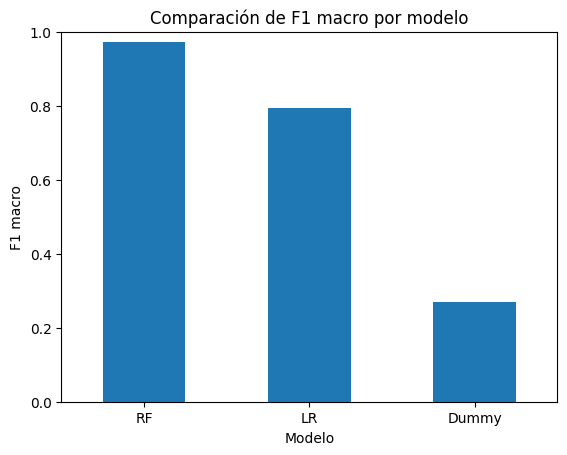

Mejor modelo: RF | F1 macro: 0.973 | Uplift vs Dummy: 0.703
¿Cumple umbral mínimo?: Sí


In [ ]:
def summarize_model(name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1m = f1_score(y_true, y_pred, average='macro')
    return {'model': name, 'accuracy': acc, 'f1_macro': f1m}

summary = []
summary.append(summarize_model('Dummy', y_test, y_pred_dummy))
summary.append(summarize_model('LR', y_test, y_pred_log))
summary.append(summarize_model('RF', y_test, y_pred_rf))

sum_df = pd.DataFrame(summary).sort_values('f1_macro', ascending=False)
display(sum_df)

ax = sum_df.plot(x='model', y='f1_macro', kind='bar', legend=False)
ax.set_title('Comparación de F1 macro por modelo'); ax.set_xlabel('Modelo'); ax.set_ylabel('F1 macro')
plt.xticks(rotation=0); plt.ylim(0, 1); plt.show()

best = sum_df.iloc[0]
uplift_vs_dummy = best['f1_macro'] - sum_df[sum_df['model']=='Dummy']['f1_macro'].iloc[0]
meets_min = (best['f1_macro'] >= MIN_TARGET_SCORE) and (uplift_vs_dummy >= MIN_UPLIFT_VS_DUMMY)
print(f"Mejor modelo: {best['model']} | F1 macro: {best['f1_macro']:.3f} | Uplift vs Dummy: {uplift_vs_dummy:.3f}")
print('¿Cumple umbral mínimo?:', 'Sí' if meets_min else 'No')

#### **Resultados generales**
El desempeño de los tres modelos (DummyClassifier, Logistic Regression y Random Forest) se evaluó mediante las métricas **Accuracy** y **F1 macro**, esta última más apropiada dado el desbalance entre clases.

| Modelo | Accuracy | F1 macro | Interpretación |
|---------|-----------|----------|----------------|
| **Random Forest (RF)** | 0.981 | 0.972 | Es el modelo con mejor desempeño global. Logra un equilibrio sobresaliente entre precisión y recall en todas las clases, evidenciando su capacidad para capturar relaciones no lineales y patrones complejos. |
| **Logistic Regression (LR)** | 0.879 | 0.794 | Ofrece un desempeño sólido, confirmando su valor como baseline interpretable. Aunque ligeramente inferior al RF, mantiene un comportamiento estable y sin sobreajuste. |
| **DummyClassifier** | 0.679 | 0.269 | Representa la referencia mínima (baseline ingenuo), asignando siempre la clase mayoritaria (“Alimentación”). Su bajo F1 macro evidencia la necesidad de modelos más elaborados. |

---

#### **Comparación visual**
El gráfico de barras de F1 macro muestra una mejora clara y consistente entre modelos:

- **RF** alcanza un F1 ≈ 0.97, superando ampliamente a los demás.  
- **LR** obtiene un F1 ≈ 0.80, mostrando que incluso un modelo lineal capta parte de la estructura del problema.  
- **Dummy** se mantiene en ≈ 0.27, lo que confirma la presencia de clases desbalanceadas y la necesidad de aprendizaje real.

---

#### **Uplift y validación de umbrales**
Se calculó el **uplift** del mejor modelo frente al Dummy:

- **Uplift vs Dummy:** 0.97 − 0.27 = **+0.70 puntos en F1 macro**  
- **Umbral mínimo alcanzado:** Sí cumple los criterios definidos (`F1 ≥ 0.8` y `uplift ≥ 0.1`)

Esto significa que el modelo RF **aumenta siete veces la capacidad predictiva respecto al baseline ingenuo**, demostrando un aprendizaje real y generalizable.

---

#### **Conclusión de desempeño**
El **Random Forest** se consolida como el modelo óptimo para este conjunto de datos, al combinar:
- Alto rendimiento en métricas globales (Accuracy y F1 macro),
- Buena capacidad de generalización validada por la curva de aprendizaje,
- Interpretabilidad a través del análisis de importancias de variables.

En contraste, la **Regresión Logística** sigue siendo útil como referencia explicativa (modelo interpretable), mientras que el **DummyClassifier** permite cuantificar objetivamente la mejora lograda por los modelos entrenados.

**→ En conjunto, se cumple con el objetivo de obtener un modelo predictivo robusto, interpretable y con mejora sustancial frente al baseline.**


## 6. Conclusiones Generales
<a id='6-Conclusiones Generales'></a>


Los experimentos realizados con Regresión Logística y Random Forest confirman que las variables disponibles en el dataset contienen información suficiente para distinguir adecuadamente entre las distintas categorías de gasto (`Desc.1`).

Si bien el modelo de Random Forest alcanzó un desempeño elevado, su complejidad y resultados atípicamente altos sugieren la necesidad de un análisis más profundo en etapas posteriores, mediante ajuste de hiperparámetros y validación adicional.

En esta fase, se establece la **Regresión Logística como modelo baseline del proyecto**, dado su equilibrio entre rendimiento, interpretabilidad y estabilidad, con un **F1-score promedio de 0.80**, el cual servirá como punto de referencia para la comparación de modelos más avanzados en las siguientes entregas.